## The math behind the photo enhancements.

The idea here is to _"reverse engineer"_ a GIMP filter, used to give a photo a certain "vintage" look. 

First let's import the necessary tools: skimage.io, matplotlib.pyplot and NumPy:

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np


Let's load an image first. 


In [2]:
image = io.imread('./my_notebooks/riogrande.jpg') #load an image as Numpy array

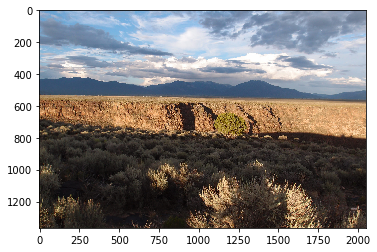

In [3]:
plt.imshow(image) # let's see what it is


Let's see how the three color channels look in this particular photo. In order to do that, we can write
a function that will take the image and display histograms of all three channels: red, green and blue.


In [4]:
def channel_splitter(image):
    '''fast numpy-based version, takes an image imported as numpy array and returns a graph 
    with three channels histograms'''
    xaxis = np.arange(256) # create the x-axis between 0 and 255
    fig, ax = plt.subplots() # initiate plots
    for number, color in enumerate(['red', 'green', 'blue']): 
        # creates pairs of channel numbers (0-2) and color names
        freqcount, _ = np.histogram(image[:,:,number], bins = np.arange(257)) 
        # gets the counts for each bin; must be one more bin as np.histogram returns bin edges
        # that is pixels with value 255 are in the bin 255-256
        ax.fill_between(xaxis, 0, freqcount, facecolor = color, alpha = 0.3) 
        #makes a graph with the correct color for each channel, transparency set to 30%
    plt.show()
        

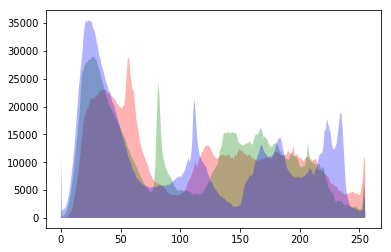

In [6]:
channel_splitter(image) #use the channel_splitter function on the image we loaded

We can see that this image has a lot of shadows, but they're not pure greys/blacks, they are shifted towards blue and green. There are also some peaks of reds, greens and blues here and there. 

Let's load a second image, a processed version of the original.

In [7]:
image_mod = io.imread('./my_notebooks/riogrande_agfa.jpg') #load the second image, processed with a filter

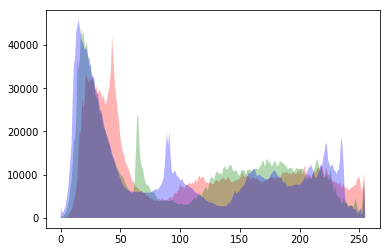

In [8]:
channel_splitter(image_mod)


Without looking at the processed version we can tell that something must have changed here. 
The peaks on the left are taller and sharper: it would indicate deeper shadows with more abrupt tonal transitions. The shadows are also greener. 

Let's look at each channel, comparing the two images. To do this, let's write another function.


In [10]:
def channel_cross_analysis(image1, image2):
    '''takes each color channel from both images and shows two overlaid histograms'''
    xaxis = np.arange(256) # create the x-axis between 0 and 255
    for number, color in enumerate(['red', 'green', 'blue']): 
            fig, ax = plt.subplots() # initiate plots    
            freqcount1, _ = np.histogram(image1[:,:,number], bins = np.arange(257))
            freqcount2, _ = np.histogram(image2[:,:,number], bins = np.arange(257))
            ax.fill_between(xaxis, 0, freqcount1, facecolor = 'gray', alpha = 0.4) # gray is the original
            ax.fill_between(xaxis, 0, freqcount2, facecolor = (color), alpha = 0.4) 
            plt.title("{} channel".format(color))
            plt.show()
        


This time we're using gray for the original image's channel and red/green/blue for the modified image.


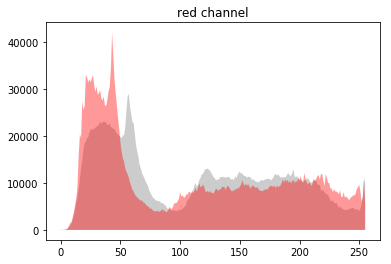

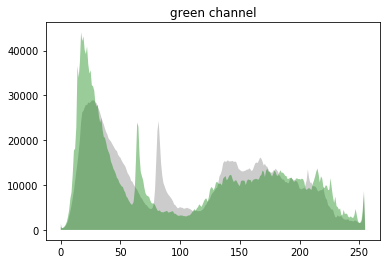

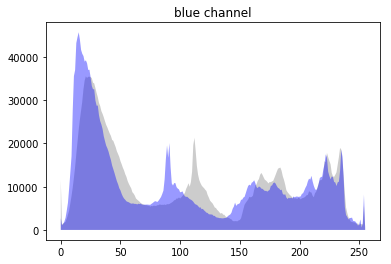

In [11]:
channel_cross_analysis(image, image_mod) #let's see how the three channels differ between the two images


Now we can see the differences more clearly: there's a boost in all three channels on the left (the shadows), with much sharper peaks. In the darker midtones there's a visible shift to the left in both green and blue channel (the peaks), a similar shift occurs also in the red channel in the shadows. These are rather subtle changes, but you can clearly see that the two images are different in tone.




(-0.5, 2047.5, 1364.5, -0.5)

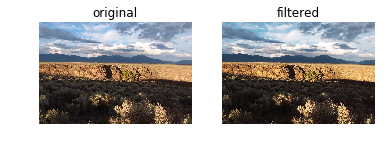

In [10]:
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[0].set_title("original")
axarr[0].axis('off')

axarr[1].imshow(image_mod)
axarr[1].set_title("filtered")
axarr[1].axis('off')



The next step will be finding the correlations between the channels of the two images... __stay tuned__!



In order to compare the two images: the original and the filtered one, we need to compare their respective channels. Here's a function to generate three charts, in order to understand what is happening to each color channel when the filter is applied. 


In [11]:
def channel_corr(image1, image2):
    '''returns charts showing the correlation between the same channels of two images'''
    for number, color in enumerate(['red', 'green', 'blue']):
        fig, ax = plt.subplots()  
        ch_im_1 = image1[:,:,number]
        ch_im_2 = image2[:,:,number]
        plt.scatter(ch_im_1,ch_im_2, c = color, alpha = 0.3)
        plt.set_xlim = (0,255)
        plt.xlabel("original image")
        plt.set_ylim = (0,255)
        plt.ylabel("modified image")
        plt.title("{} channel".format(color))
        plt.show()

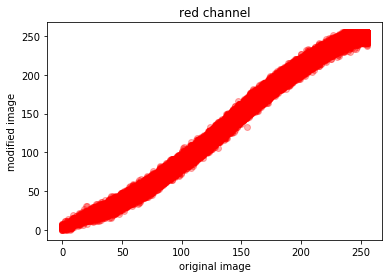

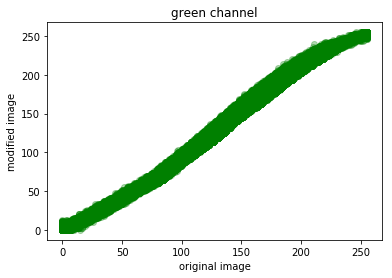

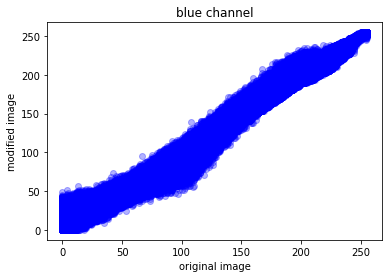

In [133]:
channel_corr(image, image_mod)


It seems like the red and the green channel are modified with some soft S-shaped curve, meanwhile the blue channel is less regular. 

Let's try simple linear regression to approximate these curves. We will use scikit-learn tools to do that.


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split



This function will create the linear regression model, split the data into train and test sets, and then after fitting display the regression line and other information.


In [47]:
def linreg(image1, image2):
    lr = LinearRegression()
    for number, color in enumerate(['red', 'green', 'blue']):
        X = np.ravel(image1[:,:,number])
        X = X.reshape(-1,1)
        y = np.ravel(image2[:,:,number])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        plt.scatter(X_test, y_test, color = color, alpha = 0.3)
        plt.plot(X_test, y_pred, color = 'black', linewidth = 2)
        print ('Coefficient: \n', lr.coef_)
        print ('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
        print ('Variance score: %.2f' % r2_score(y_test, y_pred))
        plt.show()

Coefficient: 
 [1.08639555]
Mean squared error: 30.90
Variance score: 0.99


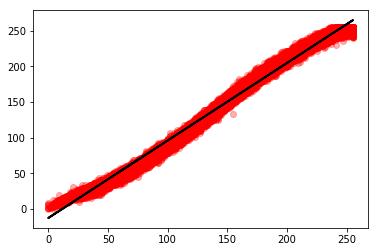

Coefficient: 
 [1.07969549]
Mean squared error: 32.67
Variance score: 0.99


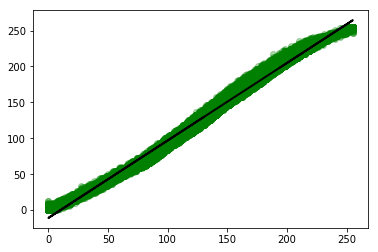

Coefficient: 
 [1.0192526]
Mean squared error: 38.33
Variance score: 0.99


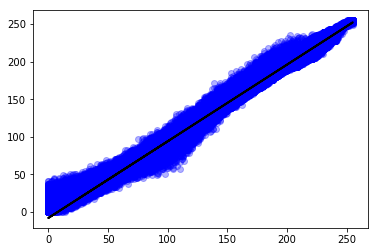

In [48]:
linreg(image, image_mod)


The variance score is very close to 1, which means a good fit. 

If you look again at the channel analysis of the two images, you will notice that not all the possible pixel values are equally represented: there's a lot of shadows, that is low values. What if we try an image with a more equal distribution? 

Let's load two random RGB noise images: the original and its filtered version, processed with the exact same filter as the first image. 


In [49]:
noise = io.imread('test_noise.jpg')

In [50]:
noise_mod = io.imread('test_noise_mod.jpg')

Coefficient: 
 [1.13767587]
Mean squared error: 346.62
Variance score: 0.91


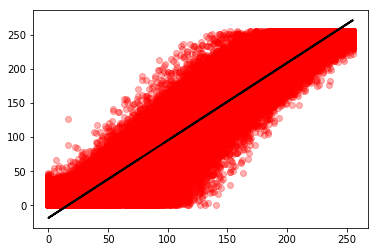

Coefficient: 
 [1.15739624]
Mean squared error: 177.55
Variance score: 0.96


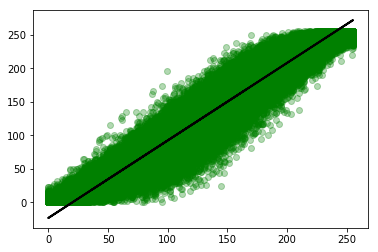

Coefficient: 
 [1.07182964]
Mean squared error: 362.30
Variance score: 0.90


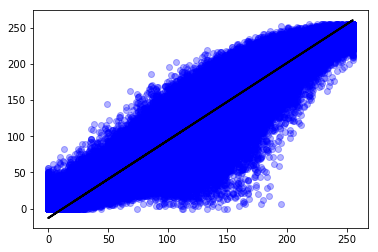

In [51]:
linreg(noise, noise_mod)


The variance scores are lower, and the mean squared errors are much higher. 

Let's see how these channels changed between the original and the filtered version:


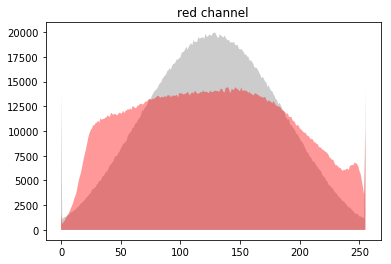

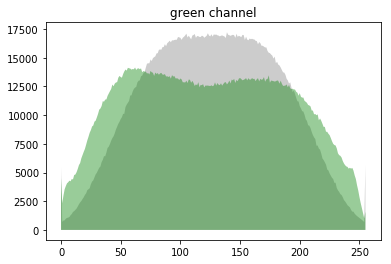

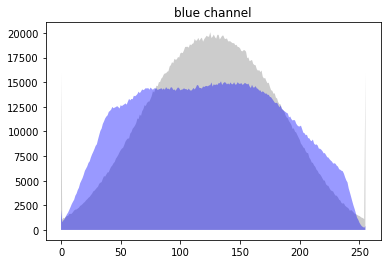

In [56]:
channel_cross_analysis(noise, noise_mod)

In [53]:
im012 = io.imread('./my_notebooks/test_images/image_012.jpg')

In [54]:
im012_mod = io.imread('./my_notebooks/test_images/image_012_mod.jpg')

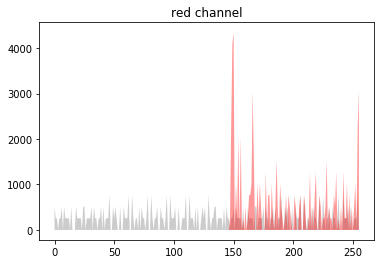

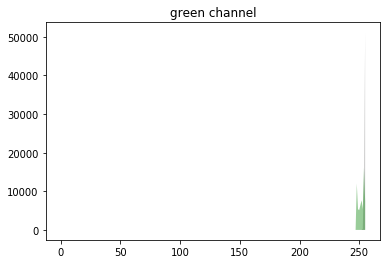

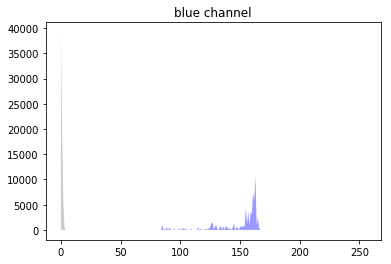

In [55]:
channel_cross_analysis(im012, im012_mod)